<a href="https://colab.research.google.com/github/OgnjenJovanovicc/Leaf-Classification-Project-Ognejn_Jovanovic_IT7-2021/blob/main/Projekat_Jovanovic_Ognjen_IT7_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import zipfile as zp
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [ ]:
def unzip(location, destination):
    with zp.ZipFile(location, 'r') as file_zip:
        file_zip.extractall(destination)

In [ ]:
def remove_labels(df, label):
    x = df.drop(label, axis=1)
    y = df[label]
    return x, y

In [ ]:
from google.colab import files
uploaded = files.upload()

unzip("Leaf_Classification.zip", "PPPO")
print(os.listdir("PPPO"))

plt.style.use('dark_background')

Saving Leaf_Classification.zip to Leaf_Classification.zip
['test.csv.zip', 'sample_submission.csv.zip', 'images.zip', 'train.csv.zip']


In [ ]:
train_data = pd.read_csv("PPPO/train.csv.zip", index_col=0)
for i in train_data.columns:
    if train_data[i].isna().any():
        print(f"{i} has null values")

In [ ]:
species = train_data[['species']]
oh = OneHotEncoder()
species_oh = oh.fit_transform(species).toarray()
species_df = pd.DataFrame(species_oh, index=train_data.index, columns=oh.categories_[0])


In [ ]:
features = train_data.drop('species', axis=1)
min_max = MinMaxScaler()
features_norm = pd.DataFrame(min_max.fit_transform(features), index=features.index, columns=features.columns)


In [ ]:
train_data_full = pd.concat([features, species_df], axis=1)
train_data_norm = pd.concat([features_norm, species_df], axis=1)

In [ ]:
train_set, val_set = train_test_split(
    train_data_full, test_size=0.3, random_state=42, stratify=species
)
train_set_norm, val_set_norm = train_test_split(
    train_data_norm, test_size=0.3, random_state=42, stratify=species
)

In [ ]:
x_train, y_train = remove_labels(train_set, oh.categories_[0])
x_train_norm, y_train_norm = remove_labels(train_set_norm, oh.categories_[0])
x_val, y_val = remove_labels(val_set, oh.categories_[0])
x_val_norm, y_val_norm = remove_labels(val_set_norm, oh.categories_[0])


In [ ]:
!pip install keras-tuner
import keras_tuner as kt

def build_model(hp):
    model = models.Sequential()
    model.add(layers.Input((x_train_norm.shape[1],)))


    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(layers.Dense(
            units=hp.Int(f'units_{i}', min_value=64, max_value=512, step=64),
            activation='relu'
        ))
        model.add(layers.Dropout(hp.Float(f'dropout_{i}', 0.2, 0.6, step=0.1)))
        model.add(layers.BatchNormalization())

    model.add(layers.Dense(99, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_results',
    project_name='leaf_classification'
)

tuner.search(x_train_norm, y_train_norm, epochs=50, validation_data=(x_val_norm, y_val_norm))
best_model = tuner.get_best_models(1)[0]


Trial 10 Complete [00h 00m 31s]
val_accuracy: 0.9797979593276978

Best val_accuracy So Far: 0.9898989796638489
Total elapsed time: 00h 04m 31s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
callbacks = [
    EarlyStopping(patience=15, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.3, patience=7),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]

In [ ]:
history = best_model.fit(
    x_train_norm, y_train_norm,
    epochs=200,
    batch_size=32,
    validation_data=(x_val_norm, y_val_norm),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/200
20/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9876 - loss: 0.1932

22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9868 - loss: 0.1981 - val_accuracy: 0.9562 - val_loss: 0.2766 - learning_rate: 0.0010
Epoch 2/200
20/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9900 - loss: 0.1912

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9896 - loss: 0.1922 - val_accuracy: 0.9630 - val_loss: 0.2344 - learning_rate: 0.0010
Epoch 3/200
15/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9916 - loss: 0.1698 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9903 - loss: 0.1693 - val_accuracy: 0.9731 - val_loss: 0.1769 - learning_rate: 0.0010
Epoch 4/200
16/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9975 - loss: 0.1310 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9957 - loss: 0.1385 - val_accuracy: 0.9764 - val_loss: 0.1657 - learning_rate: 0.0010
Epoch 5/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9895 - loss: 0.1703 - val_accuracy: 0.9798 - val_loss: 0.1883 - learning_rate: 0.0010
Epoch 6/200
15/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9968 - loss: 0.1158 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9956 - loss: 0.1209 - val_accuracy: 0.9865 - val_loss: 0.1336 - learning_rate: 0.0010
Epoch 7/200
14/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9959 - loss: 0.1084 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9937 - loss: 0.1127 - val_accuracy: 0.9798 - val_loss: 0.1084 - learning_rate: 0.0010
Epoch 8/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9946 - loss: 0.1064 - val_accuracy: 0.9764 - val_loss: 0.1278 - learning_rate: 0.0010
Epoch 9/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9885 - loss: 0.1048 - val_accuracy: 0.9731 - val_loss: 0.1199 - learning_rate: 0.0010
Epoch 10/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9944 - loss: 0.0891 - val_accuracy: 0.9697 - val_loss: 0.1300 - learning_rate: 0.0010
Epoch 11/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9943 - loss: 0.0869 - val_accuracy: 0.9697 - val_loss: 0.1382 - learning_rate: 0.0010
Epoch 12/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9957 - loss: 0.0845 - val_accuracy: 0.9832 - val_loss: 0.1095 - learning_rate: 0.0010
Epoch 13/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9913 - loss: 0.0836 - val_accuracy

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9903 - loss: 0.0750 - val_accuracy: 0.9764 - val_loss: 0.0986 - learning_rate: 0.0010
Epoch 15/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9930 - loss: 0.0642 - val_accuracy: 0.9798 - val_loss: 0.1014 - learning_rate: 0.0010
Epoch 16/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9959 - loss: 0.0757 - val_accuracy: 0.9764 - val_loss: 0.1114 - learning_rate: 0.0010
Epoch 17/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0651 - val_accuracy: 0.9798 - val_loss: 0.1062 - learning_rate: 0.0010
Epoch 18/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9958 - loss: 0.0631

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9959 - loss: 0.0627 - val_accuracy: 0.9798 - val_loss: 0.0799 - learning_rate: 0.0010
Epoch 19/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9930 - loss: 0.0639 - val_accuracy: 0.9798 - val_loss: 0.0955 - learning_rate: 0.0010
Epoch 20/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9966 - loss: 0.0529 - val_accuracy: 0.9764 - val_loss: 0.1009 - learning_rate: 0.0010
Epoch 21/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9972 - loss: 0.0553 - val_accuracy: 0.9764 - val_loss: 0.1095 - learning_rate: 0.0010
Epoch 22/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9985 - loss: 0.0497 - val_accuracy: 0.9764 - val_loss: 0.1108 - learning_rate: 0.0010
Epoch 23/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9902 - loss: 0.0618 - val_accuracy: 0.9663 - val_loss: 0.1304 - learning_rate: 0.0010
Epoch 24/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9940 - loss: 0.0483 - val_accuracy

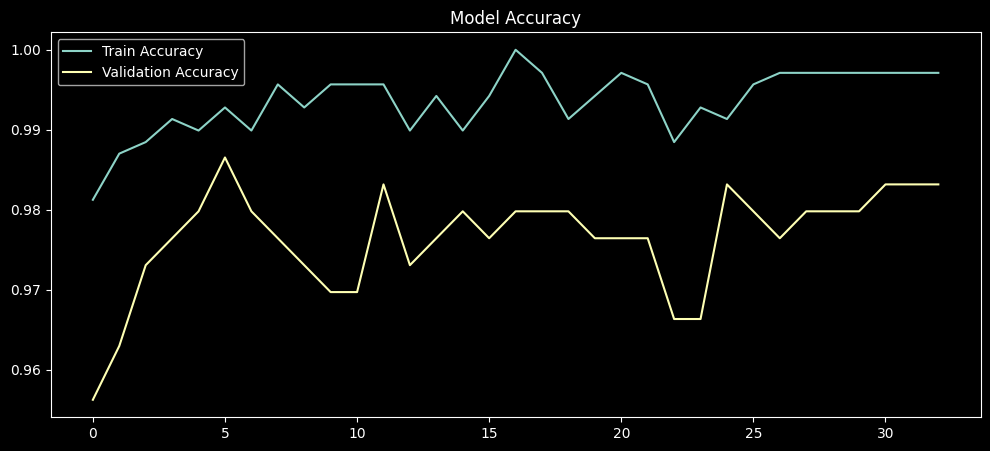

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Model Accuracy")
plt.show()

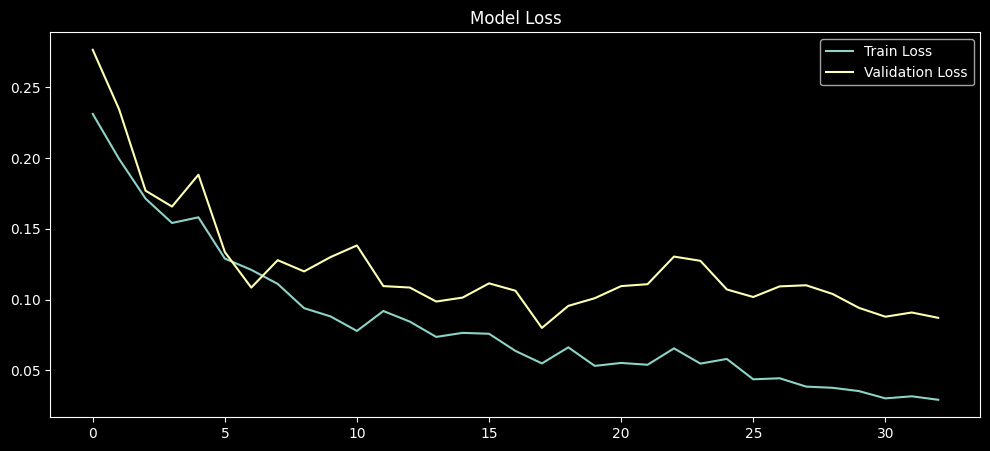

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Model Loss")
plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         3
          12       1.00      1.00      1.00         3
          13       1.00      1.00      1.00         3
          14       1.00      1.00      1.00         3
          15       1.00      1.00      1.00         3
          16    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


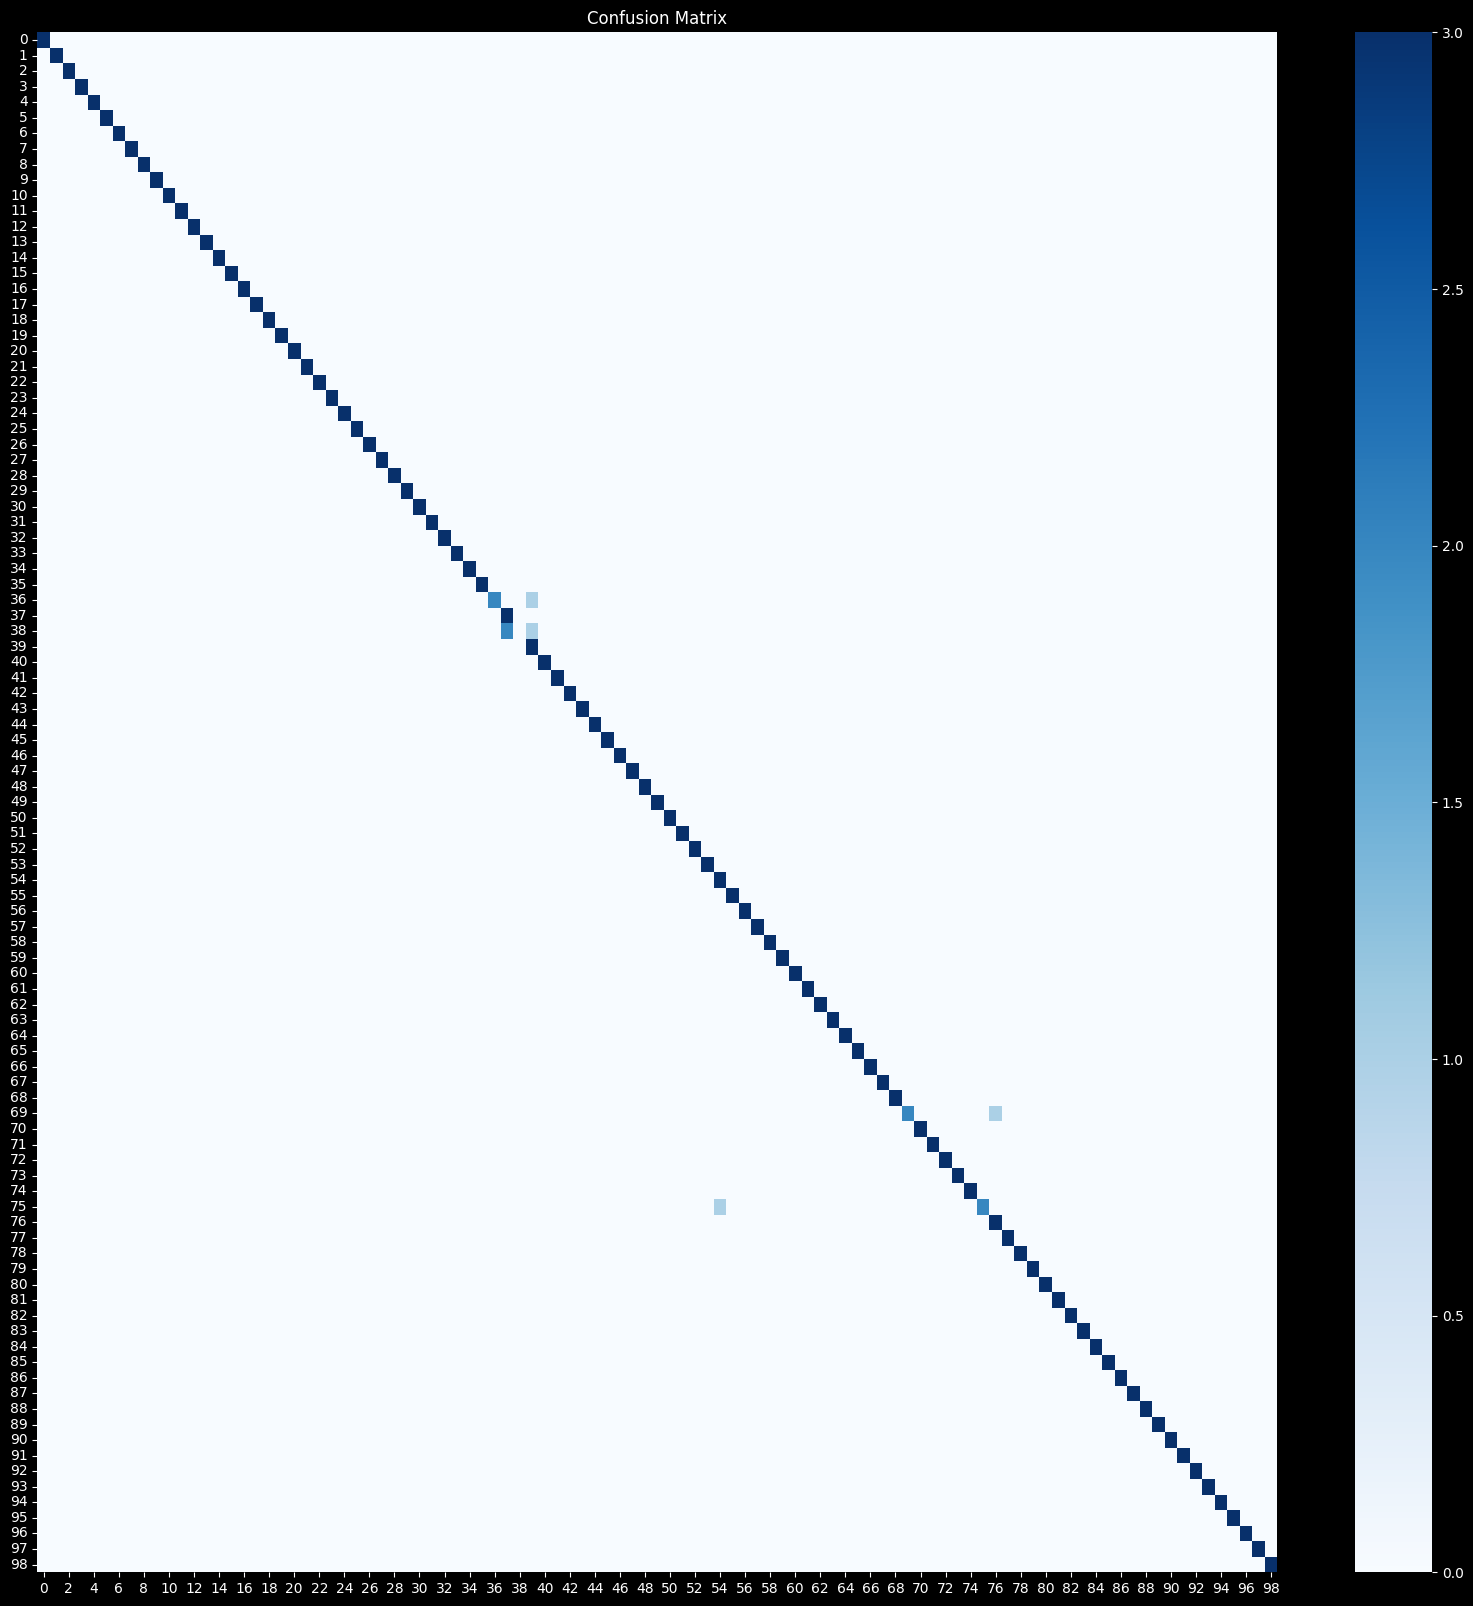

In [ ]:
y_val_pred = best_model.predict(x_val_norm)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true = np.argmax(y_val_norm.values, axis=1)

print("\nClassification Report:\n")
print(classification_report(y_val_true, y_val_pred_classes))

cm = confusion_matrix(y_val_true, y_val_pred_classes)
plt.figure(figsize=(20,20))
sns.heatmap(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [ ]:
test_data = pd.read_csv('PPPO/test.csv.zip', index_col=0)
for i in test_data.columns:
    if test_data[i].isna().any():
        print(f"{i} has null values")

test_data_norm = pd.DataFrame(min_max.transform(test_data), index=test_data.index, columns=test_data.columns)
y_pred = best_model.predict(test_data_norm)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [ ]:
submission = pd.DataFrame(y_pred, index=test_data_norm.index, columns=oh.categories_[0])
submission.to_csv('submission.csv')
print("Submission fajl sacuvan.")

Submission fajl sacuvan.
